In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from nsdmd import utils
from nsdmd import nsdmd

In [2]:
sr = 1000
return_offset = -200

f1 = 4
t1 = np.arange(0,1700)
f2 = 30
t2 = np.arange(0,1700)
f3 = 17
t3 = np.arange(1300,2500)
f4 = 30
t4 = np.arange(1300,2500)

net1, F1_true, _ = utils.make_network(f1, len(t1), \
                   np.hstack([i*np.ones(50) for i in [1,2]]), \
                   np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(0,30,10)]]),\
                   sr,\
                   utils.create_decay(len(t1),1,400))
net2, F2_true, _ = utils.make_network(f2, len(t2), \
                   np.hstack([i*np.ones(50) for i in [1,2]]), \
                   np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(-20,30,10)]]),\
                   sr,\
                   utils.create_decay(len(t2),1,400))
net3, F3_true, _ = utils.make_network(f3, len(t3), \
                   np.hstack([i*np.ones(50) for i in [2,1]]), \
                   np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(50,0,10)]]),\
                   sr,\
                   utils.create_decay(len(t3),400,1))
gauss = scipy.stats.norm(800, 200).pdf(np.arange(1200))
gauss = gauss / np.max(gauss) + 0.3
net4, F4_true, _  = utils.make_network(f4, len(t4), \
                    np.hstack([i*np.ones(50) for i in [2,1]]), \
                    np.hstack([i*np.ones(10, dtype=int) for i in [int(j) for j in np.linspace(10,-40,10)]]),\
                    sr,\
                    gauss*utils.create_decay(len(t4),400,1))
x = np.zeros((100,4300+return_offset))
x[:,t1] += net1
x[:,t2] += net2
x[:,t3] += net3
x[:,t4] += net4
x[:,-len(t1):] += net1
x[:,-len(t2):] += net2
x = utils.add_noise(x, std=0.1)
t = np.arange(x.shape[1]) / sr

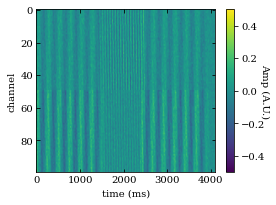

In [3]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

cax = ax.imshow(x, aspect='auto', vmin=-0.5, vmax=0.5)
cbar = fig.colorbar(cax)
cbar.set_label('Amp (A.U.)', rotation=270)
ax.set_xlabel('time (ms)')
ax.set_ylabel('channel')
# plt.savefig('figs/phase_return.svg', bbox_inches='tight')

In [4]:
model = nsdmd.NSDMD(opt_rank=4, sim_thresh_phi_amp=0.98, sim_thresh_phi_phase=1)
model.fit_opt(x, t, sr)

Text(0.5, 1.0, 'Similar Solutions')

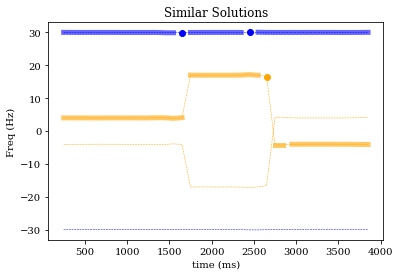

In [5]:
group_idx = nsdmd.group_by_similarity(model.freqs_, model.phis_, model.opt_stride/sr, \
                                      model.sim_thresh_freq, model.sim_thresh_phi_amp)

x_extent = np.mean(model.windows_, axis=1)
colors = ['blue', 'orange']
for i in range(len(group_idx)):
    plt.plot(x_extent, model.freqs_[:,i], linestyle='dashed', color=colors[i//2], linewidth=0.5)
    for g in group_idx[i]:
        if(len(g)>1):
            plt.plot(x_extent[g], model.freqs_[g,i], color=colors[i//2], linewidth=5, alpha=0.6)
        else:
            plt.scatter(x_extent[g], model.freqs_[g,i], color=colors[i//2])

plt.xlabel('time (ms)')
plt.ylabel('Freq (Hz)')
plt.title('Similar Solutions')

In [6]:
model.fit_reduction(x, len(t), sr)

Text(0, 0.5, 'Cosine Distance')

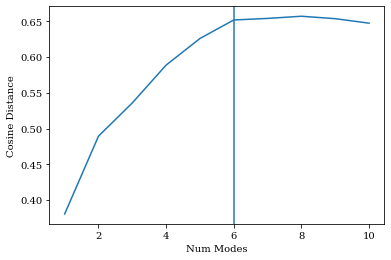

In [7]:
plt.plot(model.num_modes_, model.errors_)
plt.axvline(6)
plt.xlabel('Num Modes')
plt.ylabel('Cosine Distance')

In [8]:
model.fit_f(x, len(t), sr, 6)

/tmp/ipykernel_1632/2679013471.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + alpha)


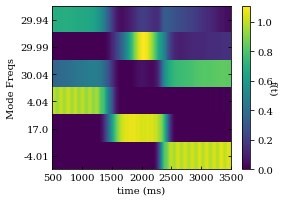

In [14]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both',which='both',direction='in',right=True,top=True)

alpha = [str(np.round(f,2)) for f in model.freq_mean_]

cax = ax.matshow(model.f_hat_[:,500:-500], aspect='auto', extent=[500,3500,6.5,0.5])
cbar = fig.colorbar(cax)
cbar.set_label('f(t)', rotation=270)
ax.set_yticklabels([''] + alpha)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('time (ms)')
ax.set_ylabel('Mode Freqs')
# plt.savefig('figs/phase_return_f.svg', bbox_inches='tight')

In [10]:
x_rec = model.transform(x, len(t), sr)

Text(0, 0.5, 'Channel')

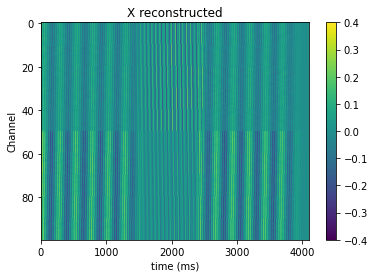

In [11]:
plt.imshow(x_rec, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X reconstructed')
plt.xlabel('time (ms)')
plt.ylabel('Channel')

Text(0, 0.5, 'Channel')

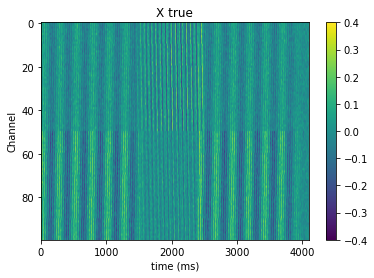

In [12]:
plt.imshow(x, aspect='auto', vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.title('X true')
plt.xlabel('time (ms)')
plt.ylabel('Channel')